# Modelo clasificador de vehículos SUV
## Deep Learning, Convolutional Neural Networks (CNN)
Autor: Felipe Catalán

- [Link del Notebook](https://github.com/FelipeCatalanPerez/CNN_SUV/blob/main/Modelo_CNN.ipynb)

El modelo que se presenta a continuación se construyó utilizando la [base de datos](http://ai.stanford.edu/~jkrause/cars/car_dataset.html) , a la cual se le realizaron modificaciones para trabajar con las siguientes clases:
- 0 = NO_SUV
- 1 = SUV

La base que se utiliza esta compuesta de 8144 imágenes etiquetadas con 6515 train, 1628 test.

## Librerias

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from torchvision import datasets
from torchvision import transforms 
import torch
import torch.nn as nn
import torch.nn.functional as F
import datetime
from torchvision import datasets, transforms
from torch import nn, optim
from torch.autograd import Variable

import os
from os import walk

from sklearn.metrics import confusion_matrix   

# estilo de imagen retina
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
SEED=42 

import pandas as pd 
pd.options.display.float_format = '{:.2f}'.format

c:\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data
### Correcto orden de las carpetas

In [2]:
# Estoy en la raiz.
print(os.listdir("data_original"))

['Cladificador_vehiculos_SUV']


In [3]:
# Reviso el contenido.
for (dirpath, dirnames, filenames) in walk("data_original"):
    print("Directory path: ", dirpath)
    print("Folder name: ", dirnames)
#    print("File name: ", filenames)

Directory path:  data_original
Folder name:  ['Cladificador_vehiculos_SUV']
Directory path:  data_original\Cladificador_vehiculos_SUV
Folder name:  ['test', 'train']
Directory path:  data_original\Cladificador_vehiculos_SUV\test
Folder name:  ['NO_SUV', 'SUV']
Directory path:  data_original\Cladificador_vehiculos_SUV\test\NO_SUV
Folder name:  []
Directory path:  data_original\Cladificador_vehiculos_SUV\test\SUV
Folder name:  []
Directory path:  data_original\Cladificador_vehiculos_SUV\train
Folder name:  ['NO_SUV', 'SUV']
Directory path:  data_original\Cladificador_vehiculos_SUV\train\NO_SUV
Folder name:  []
Directory path:  data_original\Cladificador_vehiculos_SUV\train\SUV
Folder name:  []


In [4]:
def test_network(net, trainloader):

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # Create Variables for the inputs and targets
    inputs = Variable(images)
    targets = Variable(images)

    # Clear the gradients from all Variables
    optimizer.zero_grad()

    # Forward pass, then backward pass, then update weights
    output = net.forward(inputs)
    loss = criterion(output, targets)
    loss.backward()
    optimizer.step()

    return True


def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


def view_recon(img, recon):
    ''' Function for displaying an image (as a PyTorch Tensor) and its
        reconstruction also a PyTorch Tensor
    '''

    fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)
    axes[0].imshow(img.numpy().squeeze())
    axes[1].imshow(recon.data.numpy().squeeze())
    for ax in axes:
        ax.axis('off')
        ax.set_adjustable('box-forced')

def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

### Obteniendo la Data

In [5]:
PATH = 'data_original\Cladificador_vehiculos_SUV'

In [6]:
# data_dir = 'data_original\Cladificador_vehiculos_SUV'+ '/train'
data_dir = PATH + '/train'

transform = transforms.Compose([transforms.Resize(32),
                                transforms.CenterCrop(32),
                                transforms.ToTensor(),
                                transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                    (0.2470, 0.2435, 0.2616))
                               ])
dataset = datasets.ImageFolder(data_dir, transform=transform)

In [7]:
# data_dir_t = 'data_original\Cladificador_vehiculos_SUV/test'
data_dir_t = PATH + '/test'
dataset_t = datasets.ImageFolder(data_dir_t, transform=transform)


Realizo la conversión de las imágenes para que todas sean de 32x32 pixeles, lo cambio a formato tensor y normalizo por las 3 medias y las 3 desviaciones estándar de los 3 channel o colores que tienen mis imágenes (red, blue y green).

Creo una base de datos para entrenamiento y otra para test.

<AxesSubplot: >

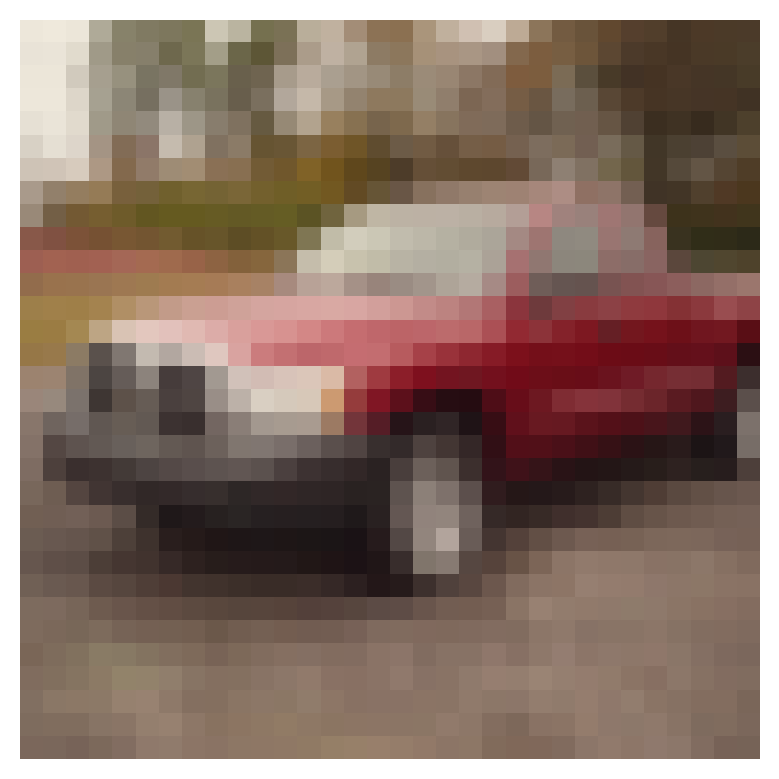

In [8]:
img, label = dataset[2]
imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


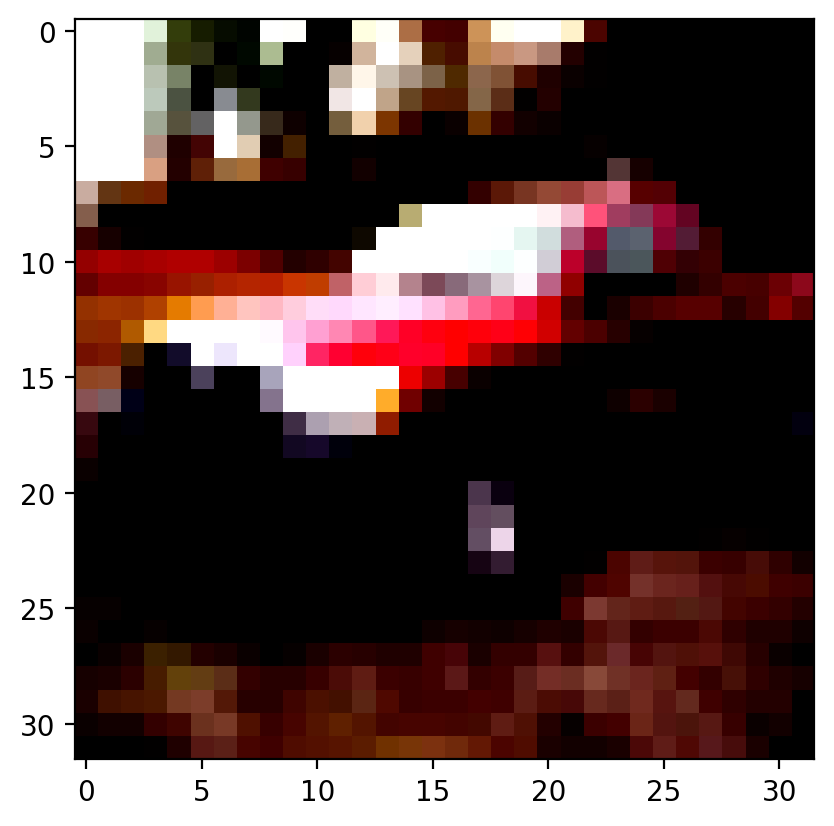

In [9]:
img, label = dataset[2]
plt.imshow(img.permute(1, 2, 0))
plt.show()


In [10]:
label

0

In [11]:
type(img)

torch.Tensor

In [12]:
print(img.shape)

torch.Size([3, 32, 32])


Vemos una imagen a la que le corresponde la etiqueta 0, es decir NO SUV.

Revisamos que corresponda a torch.Tensor, es decir el tipo de imagen que acepta el modelo y sus dimensiones.

In [13]:
# podemos seleccionar entre varias categorías 
label_map = {0:0, 1:1}
class_names = ['NO_SUV', 'SUV']

dataset_1 = [(img, label_map[label]) for img, label in dataset if label in [0, 1]]
dataset_2 = [(img, label_map[label]) for img, label in dataset_t if label in [0, 1]]

In [14]:
# Data de entrenamiento
len(dataset_1)

6515

In [15]:
# data de prueba
len(dataset_2)

1629

Para que la data ingrese al modelo realizamos un bucle que recorra el "dataset" y que extraiga cada imagen "img" de clase 0 y 1. Podria escojer enre mas clases.

## Modelo

In [88]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # convolutional layer
        self.conv2 = nn.Conv2d(64, 8, kernel_size=3, padding=1) # convolutional layer
        self.fc1 = nn.Linear(8 * 8 * 8, 32)                     # Fully connected
        self.fc2 = nn.Linear(32, 2)                             # Fully connected
    def forward(self, x): # input img
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)        # max pooling
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)      # max pooling
        out = out.view(-1, 8 * 8 * 8)                           # tranform the out
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out  # dim: number of class

### Genero un modelo CNN con 2 Convolutional layer, que implican a su vez 2 fully connected. 
1er Convolutional layer.
- channel: Se trabaja con imágenes a color por lo cual tenemos 3 channel. (Blanco y negro = 1)
- hiperparametro: a partir de cada imagen voy a crear 16 más, se puede ir cambiando para mejorar el modelo (8,16,32,64,128).
- kernel_size: corresponde al filtro de 3(el más usado), pero puede ser (2 a 5).
- padding: se usa un 1 para ir recorriendo de a 1 píxel cuando se trabaja la imagen, pero puede ser hasta 0-3.

2do Convolutional layer.
- 16 porque debe ser igual al hiperparametro anterior
- el 8 deriva de los típicos valores para el hiperparametro (8,16,32,64,128)

1er Fully connected layer.
- el input de 8x8x8:
- el output es 32, toda la info de un layer gigante reducida.

2do Fully connected layer.
- el input es 32 dado que se toma el output del anterior Fully connected layer.
- el ultimo valor que sale de la red es 2, porque corresponde a las 2 categorías a predecir.

### 2da def forward.
Tomamos el "1er Convolutional layer" y aplicamos una función de activacion torch.tanh y aplicamos un max_pool2d, que es para reducir el tamaño de la matriz. Hacemos lo mismo con el otro.

x es n vector : [batch_size, channel, h, w]

utilizo un max pooling de 2, por lo tanto, corto en 2 los input iniciales de 16 <--> 32

In [89]:
# instanciar: la llamo por su nobre
model = CNN()

In [90]:
# [batch_size(1=una imagen), channel, h, w] -> simulo la imagen
mt = torch.randn(1,3,32,32)

In [91]:
model(mt)

tensor([[-0.0703,  0.0084]], grad_fn=<AddmmBackward0>)

In [92]:
model(mt).shape

torch.Size([1, 2])

Testeamos si el modelo funciona, simulando un dato y viendo un resultado.

In [93]:
# Training function 
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    loss_list = []
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0 
        for imgs, labels in train_loader:  # batch 
            outputs = model(imgs)
            loss = loss_fn(outputs, labels) # Y estimado y valor real
            optimizer.zero_grad()
            loss.backward()               # backpro
            optimizer.step()              # update w
            
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('Epoch {}, Training loss {}'.format(epoch,
            loss_train / len(train_loader)))
            loss_list.append(loss_train / len(train_loader))
    return loss_list

### El training loop: 
1er for.
- epoch: cuantas veces vamos a pasar toda la muestra por el modelo.
- loss_train: guarda los valores de la loss

2do for.
- train_loader: es la data con las imágenes y las categorías.
- La imagen pasa por el modelo y el modelo da un output
- Ese output se compara con los labels y obtengo la función de perdida. ["output"--> ¿prediccion del modelo?]
- loss.backward(): calculo del backpropagation, las derivadas parciales para los parametros.
- Itero sobre todo esto.

Finalmente retorno los valores de la función de perdida, para saber si el modelo está entrenando o no. (epoch % 10 == 0:... --> lo entrega cada 10 iteraciones)

In [94]:
train_loader = torch.utils.data.DataLoader(dataset_1, batch_size=64, shuffle=True)

In [95]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

- batch_size: Nos ayuda a entregarle las imágenes en grupos al modelo, en este caso en grupos de a 64 imágenes.
- shuffle: reordena las imágenes en distinta forma para que el modelo no memorice tanto las imágenes.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


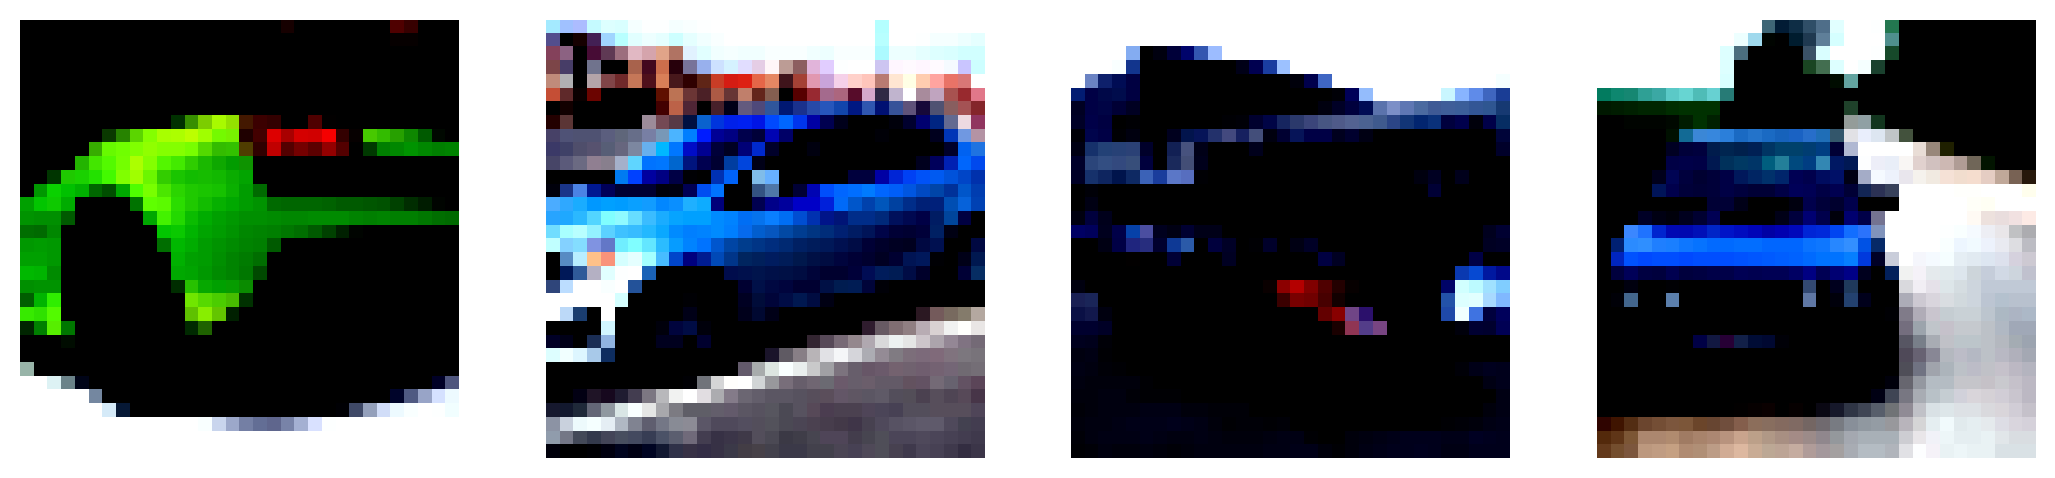

In [96]:
# change this to the trainloader or testloader 
data_iter = iter(train_loader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(13,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
#     helper.imshow(images[ii], ax=ax, normalize=False)
    imshow(images[ii], ax=ax, normalize=False)

Revisando algunas imágenes que entran al modelo

In [97]:
# Run, traning
model = CNN()                                      # call our cnn class
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # Stochastic gradient descent, Lr:0.1,0.01,0.001
loss_fn = nn.CrossEntropyLoss()                    # Loss function

Loss1 = training_loop(
    n_epochs = 80,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

Epoch 1, Training loss 0.48948849796080124
Epoch 10, Training loss 0.4450366608068055
Epoch 20, Training loss 0.43166112636818604
Epoch 30, Training loss 0.4170045499123779
Epoch 40, Training loss 0.40165890899359014
Epoch 50, Training loss 0.385356307906263
Epoch 60, Training loss 0.3682636265076843
Epoch 70, Training loss 0.3566026563445727
Epoch 80, Training loss 0.3365560330304445


¿Que funcion de perdida (loss_fn) tengo que usar?
- Uso Cross entropy loss porque estoy haciendo clasificacion.

El optimizer es el Stochastic gradient descent, pero podria ser otro, lo usamos para encontrar los parametros optimos que nos ayuden a encontrar la funcion de perdida, Lr:01, 0.01, 0.001

¿Cuantas veces voy a pasar la base de datos por el modelo?
- n_epochs, nos entrega cada 10 iteraciones.

Text(0, 0.5, 'Loss')

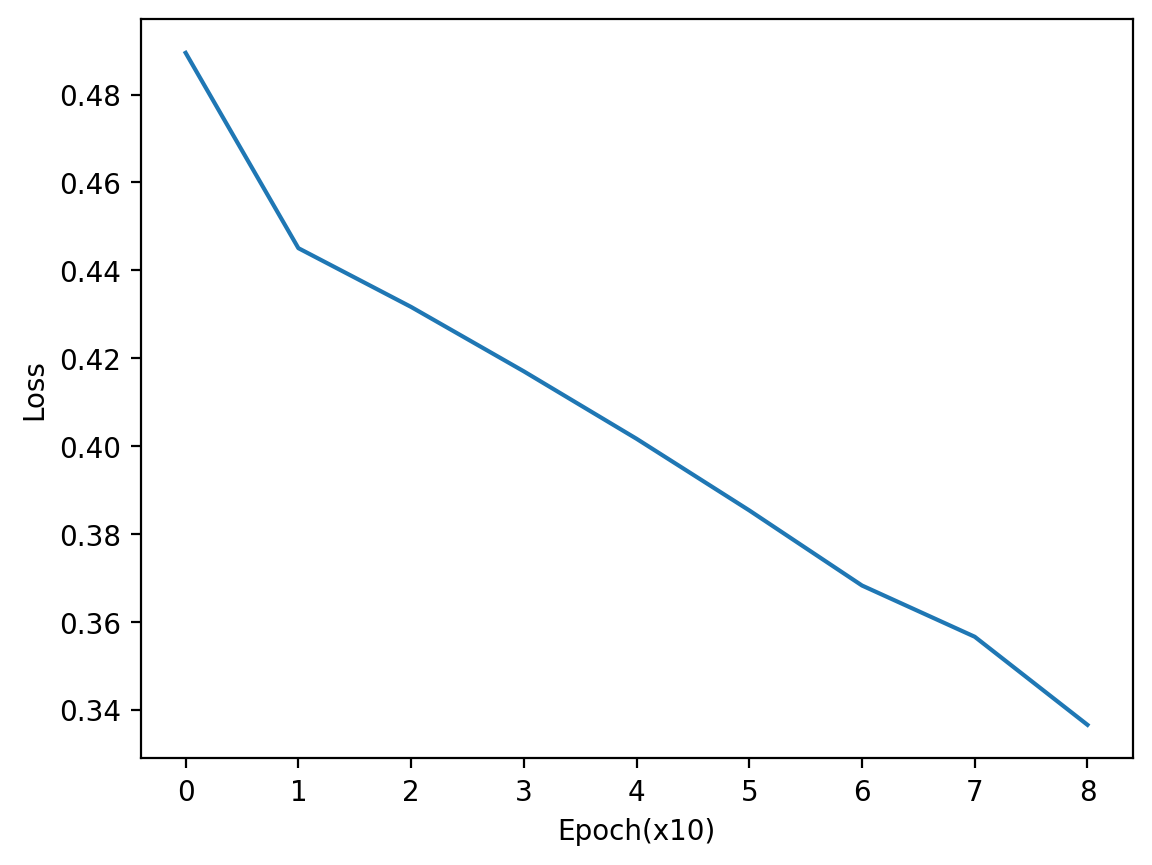

In [98]:
# plot loss
plt.plot(Loss1)
plt.xlabel('Epoch(x10)')
plt.ylabel('Loss')

Yo espero de esta funcion de perdida que sea cercana a cero y que sea estable. Cuando la curba se aplana con el eje x puedo decir que estoy en un proceso de conbergencia

In [99]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

## Resultados

Accuracy train: 0.87
Accuracy val: 0.80


C:\Users\felip\AppData\Local\Temp\ipykernel_16068\15770427.py:38: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax= plt.subplot()


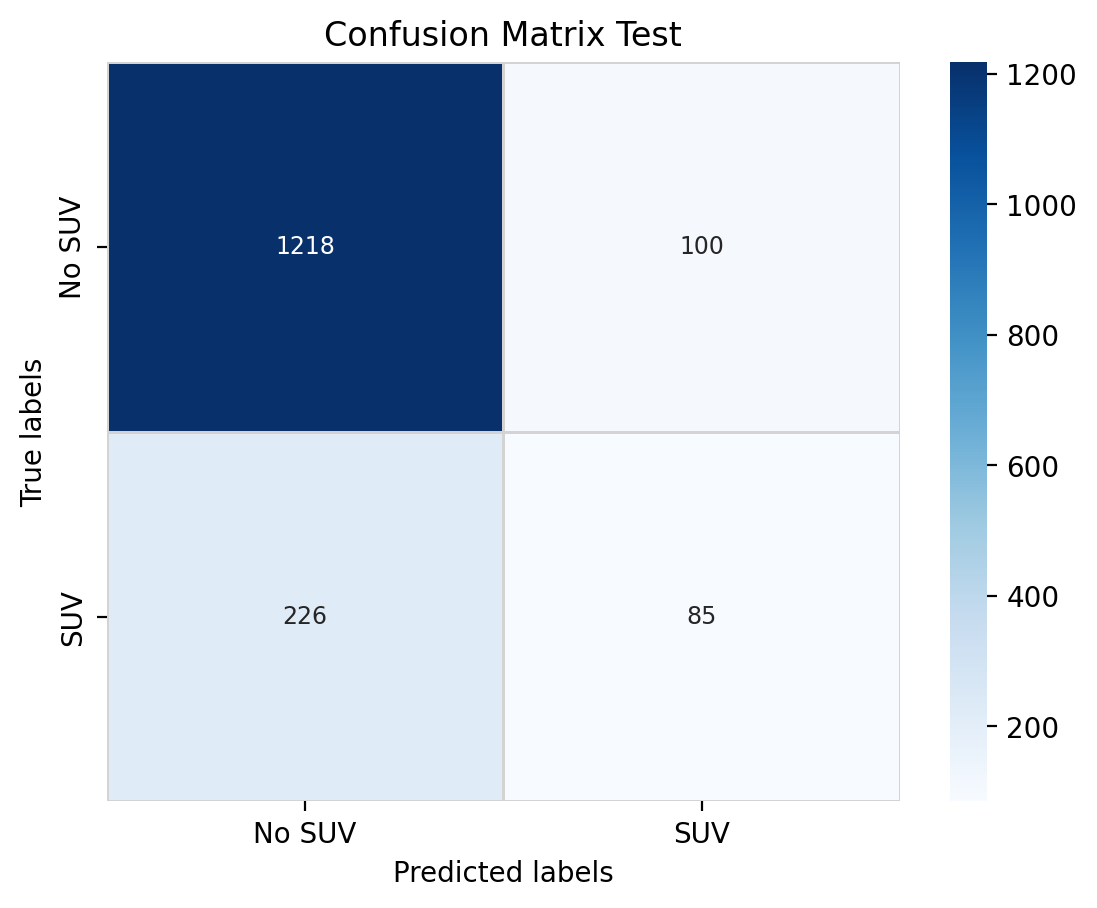

In [100]:
# Testing metric
train_loader = torch.utils.data.DataLoader(dataset_1, batch_size=64,
                                            shuffle=False)
val_loader = torch.utils.data.DataLoader(dataset_2, batch_size=64,
                                            shuffle=False)

def validate_train(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        FalsoN = 0
        FalsoP = 0
        Real_suv = 0
        Real_Nosuv = 0
        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                ## metrics: Acc, F1, AUC, Precision, Recall,
                # funciona porque tengo solo 2 clases
                correct += int((predicted == labels).sum())
                FalsoN += int((predicted > labels).sum())
                FalsoP += int((predicted < labels).sum())
                Real_suv += int((labels == 1).sum())
                Real_Nosuv += int((labels == 0).sum())
        print("Accuracy {}: {:.2f}".format(name , correct / total))
        TrueN = Real_suv-FalsoP
        TrueP = Real_Nosuv-FalsoN
        confusion_matriz = np.array([[TrueP,FalsoN],[FalsoP,TrueN]])

        def plot_matriz_confusion(cf, CMAP='Blues'):
            """Recibe un array con la matriz de confusion"""
            classes = ['No SUV','SUV']
            df_cm_log = pd.DataFrame(cf,
                                    index = [i for i in classes],
                                    columns = [i for i in classes])
            ax= plt.subplot()
            sns.heatmap(df_cm_log, annot=True, cmap=CMAP, linewidth=.5,
                        linecolor='lightgrey',fmt='g' , annot_kws={'size': 8.5});
            ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
            ax.set_title('Confusion Matrix Test')

        plot_matriz_confusion(confusion_matriz)
validate_train(model, train_loader, val_loader)

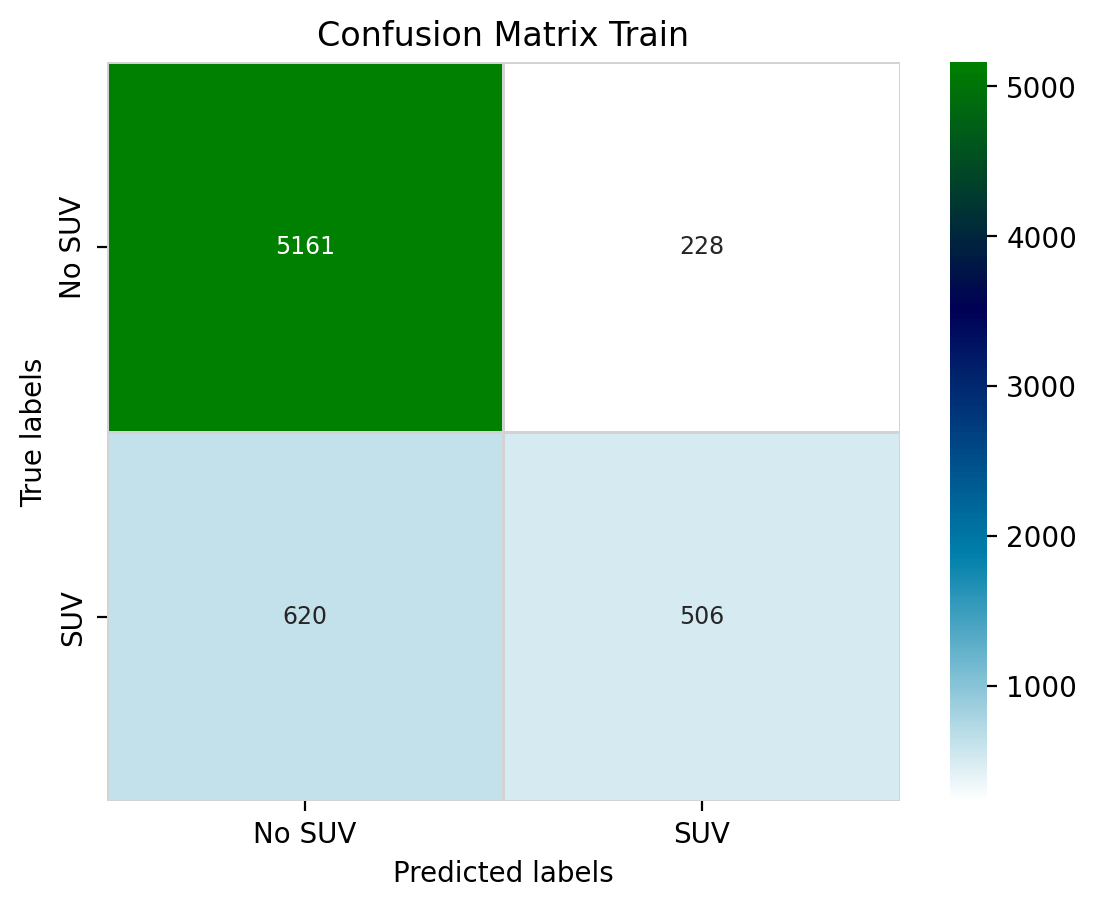

In [101]:
def validate_train(model, train_loader, val_loader):
    for name, loader in [("train", train_loader)]:
        total = 0
        FalsoN = 0
        FalsoP = 0
        Real_suv = 0
        Real_Nosuv = 0
        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                ## metrics: Acc, F1, AUC, Precision, Recall,
                FalsoN += int((predicted > labels).sum())
                FalsoP += int((predicted < labels).sum())
                Real_suv += int((labels == 1).sum())
                Real_Nosuv += int((labels == 0).sum())
        TrueN = Real_suv-FalsoP
        TrueP = Real_Nosuv-FalsoN
        
        confusion_train = np.array([[TrueP,FalsoN],[FalsoP,TrueN]])

        def plot_matriz_confusion(cf, CMAP='ocean_r'):
            """Recibe un array con la matriz de confusion"""
            classes = ['No SUV','SUV']
            df_cm_log = pd.DataFrame(cf,
                                    index = [i for i in classes],
                                    columns = [i for i in classes])
            ax= plt.subplot()
            sns.heatmap(df_cm_log, annot=True, cmap=CMAP, linewidth=.5,
                        linecolor='lightgrey',fmt='g' , annot_kws={'size': 8.5});
            ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
            ax.set_title('Confusion Matrix Train')

        plot_matriz_confusion(confusion_train)
validate_train(model, train_loader, val_loader)

Gracias a que los valores de Accuracy son cercanos para las divisiones de la data train y test, es posible descartar la existencia de overffiting en el modelo, además se consiguieron valores altos lo cual es un buen indicio ya que el modelo clasifica de forma correcta mas del 80% de las observaciones.

Sin embargo, gracias a la elaboración de las matrices de confusión se sabe que en el entrenamiento el modelo aprendió a clasificar muy bien los vehículos que no corresponden a SUV con 5161 observaciones acertadas, pero el modelo solo clasifico correctamente a 506 vehículos SUV mientras que en 620 casos clasifico a SUV como otros vehículos y 228 veces clasifico a otros vehículos como SUV.

Por lo expuesto anteriormente es posible concluir que es necesaria una mayor cantidad de imágenes de vehículos SUV para que el modelo pueda identificar mejor sus características, y se logre una clasificación más acertada. Además, esto se debe a la mayor cantidad de imágenes de vehículos No SUV, dada la conformación original de la data en donde las imágenes venían distribuidas de forma equitativa para 196 modelos diferentes de vehículos.